In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---
print(" Loading Data and Scaling Features...")

# Load the dataset
df = pd.read_csv("data.csv")

# Feature columns for clustering (all numerical columns)
clustering_feature_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
X_data_all = df[clustering_feature_cols].values

# Min-Max Scaling: Normalizes all features to [0, 1]
min_vals = X_data_all.min(axis=0)
range_vals = X_data_all.max(axis=0) - min_vals
X_scaled_all = (X_data_all - min_vals) / range_vals
N = X_scaled_all.shape[0]

# --- Shared Function: Euclidean Distance ---
def euclidean_distance(a, b):
    """Calculates the Euclidean distance between two points/arrays."""
    return np.sqrt(np.sum((a - b)**2))



 Loading Data and Scaling Features...


In [10]:
# --- Implement PCA from Scratch for Visualization (Reducing to 2D) ---


# Center the data by subtracting the mean of each feature
X_centered = X_scaled_all - np.mean(X_scaled_all, axis=0)

# Calculate the covariance matrix
covariance_matrix = np.cov(X_centered, rowvar=False)

# Calculate eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

# Sort the eigenvectors by decreasing eigenvalues
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigen_vectors = eigen_vectors[:, sorted_index]

# Select the first two principal components
principal_components = sorted_eigen_vectors[:, 0:2]

# Project the centered data onto the 2 principal components
X_pca = X_centered @ principal_components



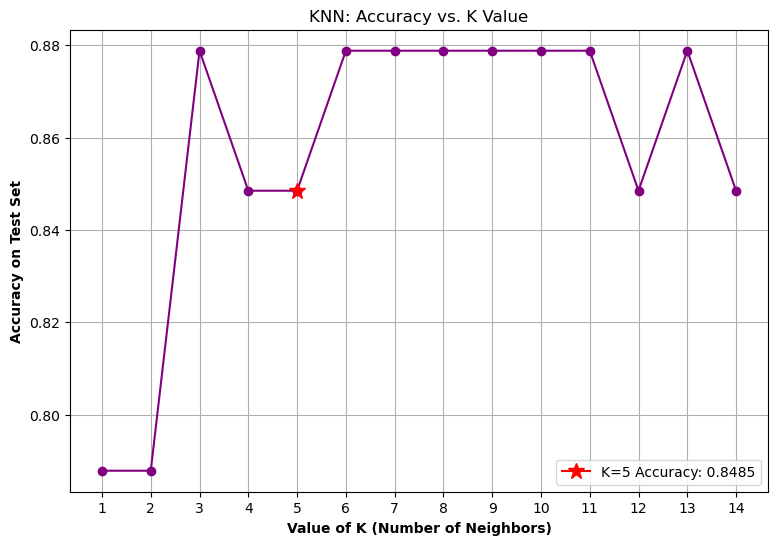

KNN Classification (K=5) Accuracy: 0.8485


In [11]:
# --- KNN (Classification) Functions and Setup ---


knn_feature_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']
X_knn_data = df[knn_feature_cols].values
X_knn_scaled = (X_knn_data - X_knn_data.min(axis=0)) / (X_knn_data.max(axis=0) - X_knn_data.min(axis=0))

median_gdpp = df['gdpp'].median()
y_data_knn = (df['gdpp'] > median_gdpp).astype(int).values

# Data Splitting
np.random.seed(42)
shuffled_indices = np.random.permutation(X_knn_scaled.shape[0])
test_set_size = int(X_knn_scaled.shape[0] * 0.2)
train_indices = shuffled_indices[test_set_size:]
test_indices = shuffled_indices[:test_set_size]
X_train, X_test = X_knn_scaled[train_indices], X_knn_scaled[test_indices]
y_train, y_test = y_data_knn[train_indices], y_data_knn[test_indices]

# KNN Functions
def find_neighbors(X_train, y_train, test_point, k):
    distances = []
    for i, train_point in enumerate(X_train):
        dist = euclidean_distance(test_point, train_point)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    return [neighbor[1] for neighbor in distances[:k]]

def predict_classification(neighbor_labels):
    counts = np.bincount(neighbor_labels)
    return np.argmax(counts)

def knn_classifier(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        neighbor_labels = find_neighbors(X_train, y_train, test_point, k)
        predictions.append(predict_classification(neighbor_labels))
    return np.array(predictions)

def calculate_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# --- KNN EXECUTION & VISUALIZATION ---
k_value_knn = 5
y_pred_k5 = knn_classifier(X_train, y_train, X_test, k_value_knn)
accuracy_k5 = calculate_accuracy(y_test, y_pred_k5)

# Visualization: Accuracy vs K
k_values_knn = range(1, 15)
accuracies = [calculate_accuracy(y_test, knn_classifier(X_train, y_train, X_test, k)) for k in k_values_knn]

plt.figure(figsize=(9, 6))
plt.plot(k_values_knn, accuracies, marker='o', linestyle='-', color='purple')
plt.plot(k_value_knn, accuracy_k5, marker='*', markersize=12, color='red', label=f'K={k_value_knn} Accuracy: {accuracy_k5:.4f}')
plt.xlabel('Value of K (Number of Neighbors)', fontweight='bold')
plt.ylabel('Accuracy on Test Set', fontweight='bold')
plt.title('KNN: Accuracy vs. K Value')
plt.xticks(np.arange(min(k_values_knn), max(k_values_knn)+1, 1))
plt.grid(True)
plt.legend()
plt.show()

print(f"KNN Classification (K={k_value_knn}) Accuracy: {accuracy_k5:.4f}")

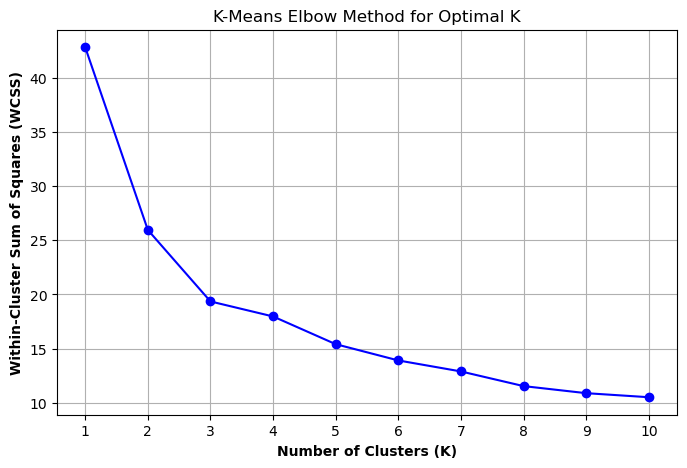

K-Means Elbow Method executed. Choose K for final visualization.


In [12]:
# --- K-Means Clustering Functions ---


def initialize_centroids(X, k, seed=42):
    np.random.seed(seed)
    random_idx = np.random.permutation(X.shape[0])[:k]
    return X[random_idx]

def assign_clusters(X, centroids):
    n_samples = X.shape[0]
    clusters = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        distances = [euclidean_distance(X[i], centroid) for centroid in centroids]
        clusters[i] = np.argmin(distances)
    return clusters

def update_centroids(X, clusters, k):
    n_features = X.shape[1]
    new_centroids = np.zeros((k, n_features))
    for cluster_idx in range(k):
        points_in_cluster = X[clusters == cluster_idx]
        if len(points_in_cluster) > 0:
            new_centroids[cluster_idx] = np.mean(points_in_cluster, axis=0)
    return new_centroids

def kmeans(X, k, max_iter=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iter):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return clusters, centroids

def calculate_wcss_for_clusters(X, clusters):
    # Calculates WCSS based on dynamically calculated cluster centroids
    wcss = 0
    k = len(np.unique(clusters))
    for cluster_idx in range(k):
        points_in_cluster = X[clusters == cluster_idx]
        if len(points_in_cluster) > 0:
            centroid = np.mean(points_in_cluster, axis=0)
            wcss += np.sum((points_in_cluster - centroid)**2)
    return wcss

# --- K-Means EXECUTION & VISUALIZATION (Elbow Plot) ---
k_range_kmeans = range(1, 11)
wcss_values_kmeans = []
for k in k_range_kmeans:
    clusters_k, _ = kmeans(X_scaled_all, k)
    wcss_values_kmeans.append(calculate_wcss_for_clusters(X_scaled_all, clusters_k))

plt.figure(figsize=(8, 5))
plt.plot(k_range_kmeans, wcss_values_kmeans, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters (K)', fontweight='bold')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontweight='bold')
plt.title('K-Means Elbow Method for Optimal K')
plt.xticks(k_range_kmeans)
plt.grid(True)
plt.show()

print("K-Means Elbow Method executed. Choose K for final visualization.")

In [13]:
# --- Hierarchical Clustering Functions ---


def agglomerative_clustering(X):
    # Generates the Linkage Matrix (Z) using Single Linkage
    Z = [] 
    cluster_sizes = np.ones(N)
    dist_matrix = np.full((N, N), np.inf)
    for i in range(N):
        for j in range(i + 1, N):
            dist_matrix[i, j] = dist_matrix[j, i] = euclidean_distance(X[i], X[j])
    
    for _ in range(N - 1):
        min_dist = np.inf
        row_idx, col_idx = -1, -1
        for i in range(N):
            for j in range(i + 1, N):
                if dist_matrix[i, j] < min_dist:
                    min_dist = dist_matrix[i, j]
                    row_idx, col_idx = i, j

        if row_idx > col_idx: row_idx, col_idx = col_idx, row_idx

        new_size = cluster_sizes[row_idx] + cluster_sizes[col_idx]
        Z.append([row_idx, col_idx, min_dist, new_size])
        
        # Single Linkage update
        for k in range(N):
            if k != row_idx and k != col_idx:
                new_dist = min(dist_matrix[row_idx, k], dist_matrix[col_idx, k])
                dist_matrix[row_idx, k] = dist_matrix[k, row_idx] = new_dist
        
        # Mark merged cluster (col_idx) as inactive
        dist_matrix[col_idx, :] = dist_matrix[:, col_idx] = np.inf
        dist_matrix[row_idx, row_idx] = np.inf
        cluster_sizes[row_idx] = new_size
        cluster_sizes[col_idx] = 0
        
    return np.array(Z)

def fcluster(Z, t):
    # Cuts the Z matrix to yield 't' clusters
    point_to_label = list(range(N))
    current_label_map = list(range(N))
    for merge_idx, row in enumerate(Z):
        idx_a, idx_b = int(row[0]), int(row[1])
        label_a = current_label_map[idx_a]
        label_b = current_label_map[idx_b]
        new_label = min(label_a, label_b)
        
        for i in range(N):
            if point_to_label[i] == label_a or point_to_label[i] == label_b:
                point_to_label[i] = new_label
        current_label_map[idx_a] = new_label
        
        if len(set(point_to_label)) == t: break
            
    unique_labels = sorted(list(set(point_to_label)))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    return np.array([label_map[label] for label in point_to_label])

# --- HIERARCHICAL EXECUTION ---
Z_matrix = agglomerative_clustering(X_scaled_all)

print("\n--- LINKAGE MATRIX (Z) SAMPLE (First 5 Merges) ---")
print(pd.DataFrame(Z_matrix[:5], columns=['Cluster 1', 'Cluster 2', 'Distance', 'Size']).to_markdown(index=False))


--- LINKAGE MATRIX (Z) SAMPLE (First 5 Merges) ---
|   Cluster 1 |   Cluster 2 |   Distance |   Size |
|------------:|------------:|-----------:|-------:|
|          41 |         121 |  0.0429786 |      2 |
|          75 |         139 |  0.0590124 |      2 |
|          24 |          85 |  0.0697177 |      2 |
|          24 |          92 |  0.074491  |      3 |
|          24 |         100 |  0.080048  |      4 |


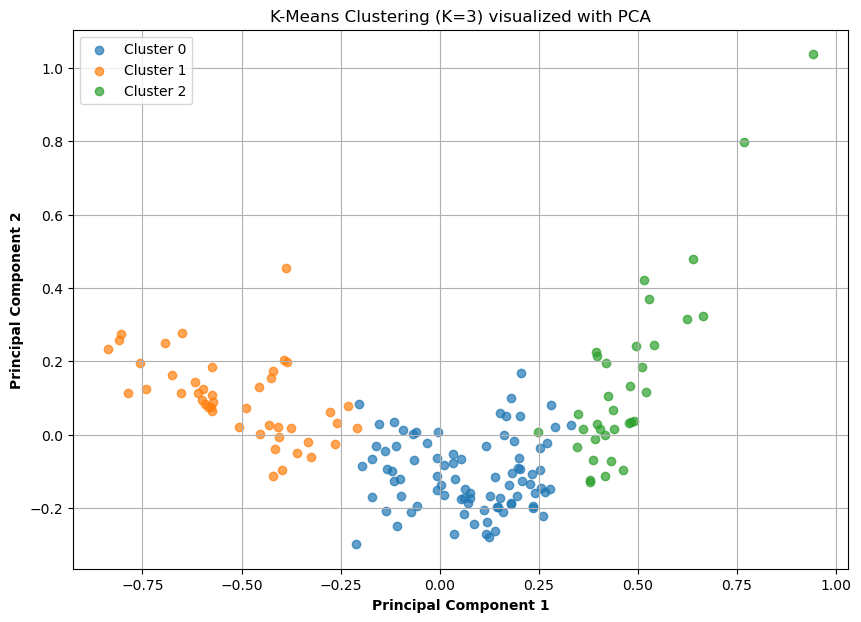

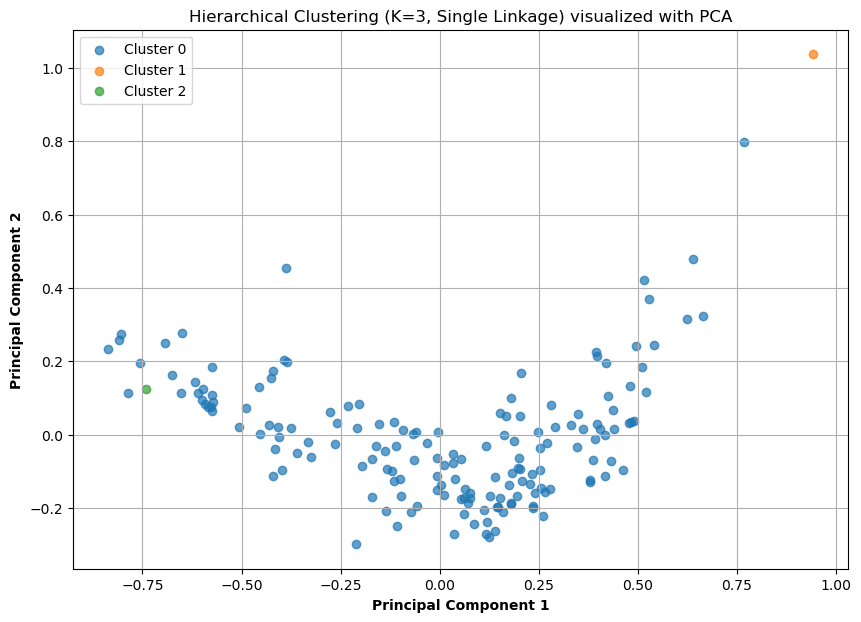


--- FINAL PERFORMANCE COMPARISON ---
1. KNN Classification (K=5):
   Accuracy: 0.8485

2. K-Means Clustering:
   WCSS (K=3): 19.3520

3. Hierarchical Clustering (Single Linkage):
   WCSS (K=3): 39.4799


In [14]:
# --- FINAL CLUSTERING EXECUTION AND MERGING ---


K_clusters_compare = 3 # Use K=3 for visual comparison
clusters_kmeans, _ = kmeans(X_scaled_all, K_clusters_compare)
wcss_kmeans = calculate_wcss_for_clusters(X_scaled_all, clusters_kmeans)

clusters_hierarchical = fcluster(Z_matrix, K_clusters_compare)
wcss_hierarchical = calculate_wcss_for_clusters(X_scaled_all, clusters_hierarchical)

# Create DataFrame for Visualization
final_clustering_df = pd.DataFrame({
    'Country': df['country'],
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'KMeans_Cluster': clusters_kmeans,
    'Hierarchical_Cluster': clusters_hierarchical
})

# --- VISUALIZATION FUNCTIONS ---
def plot_clustering_results(df, cluster_col, title, filename):
    plt.figure(figsize=(10, 7))
    for cluster_id in range(K_clusters_compare):
        cluster_points = df[df[cluster_col] == cluster_id]
        plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster_id}', alpha=0.7)
    plt.xlabel('Principal Component 1', fontweight='bold')
    plt.ylabel('Principal Component 2', fontweight='bold')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# K-Means Cluster Plot
plot_clustering_results(final_clustering_df, 'KMeans_Cluster', f'K-Means Clustering (K={K_clusters_compare}) visualized with PCA', 'kmeans_pca_clusters.png')

# Hierarchical Cluster Plot
plot_clustering_results(final_clustering_df, 'Hierarchical_Cluster', f'Hierarchical Clustering (K={K_clusters_compare}, Single Linkage) visualized with PCA', 'hierarchical_pca_clusters.png')


# --- PERFORMANCE COMPARISON ---
knn_final_accuracy = calculate_accuracy(y_test, knn_classifier(X_train, y_train, X_test, k_value_knn))

print("\n--- FINAL PERFORMANCE COMPARISON ---")
print(f"1. KNN Classification (K={k_value_knn}):")
print(f"   Accuracy: {knn_final_accuracy:.4f}")
print("\n2. K-Means Clustering:")
print(f"   WCSS (K={K_clusters_compare}): {wcss_kmeans:.4f}")
print("\n3. Hierarchical Clustering (Single Linkage):")
print(f"   WCSS (K={K_clusters_compare}): {wcss_hierarchical:.4f}")